# Introduction

The demand for detailed forest inventories is growing, fueled by the need for quality
data for harvest and afforestation planning, sustainable forest management and
conservation, modeling of carbon stock and carbon cycles, and more.
The increasing accessibility of UAVs and LiDAR sensors makes UAV LiDAR an ever more
valuable tool for conducting such inventories.
The technical characteristics of modern sensors alalow for very dense measurements,
which in turn introduce a shift from the area-based approach [@whiteABAGuide2013]
dominating early research and applications of LiDAR in forestry and still widely used in
the industry to an individual tree-based approach.
This shift brings the requirement for algorithms for automatic detection and
segmentation of individual trees within larger point clouds.
This problem can be solved well for forest stands that are either predominantly
coniferous or sparse, even by simple local maxima detection algorithms on rasterized
point clouds [@eysnAlpineITDBenchmark2015].
However, it remains an open challenge to develop a universal, robust detection approach
for dense mixed forests, in which the canopy structure is complex.
There is a growing body of research on developing and applying more complex and precise
methods, but most results that can be considered successful from the industrial adoption
point of view are in more mild forest types [@balsiSingletreeDetectionHighdensity2018,
@jeronimoApplyingLiDARIndividual2018].

In this study, we try to gain insight into the problem of tree detection and
segmentation by looking at its expected output. We analyze a collection of individual
trees manually identified in the large survey data over a dense mixed forest and explore
their features and properties.

In [1]:
#| label: imports

import glob

import laspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#| label: prepare-data

file_paths = glob.glob("data/*/*.las")
file_paths.sort()

data = pd.DataFrame({"path": file_paths})
data["species"] = data["path"].map(lambda p: p.split("/")[-2])

# Materials and methods

The dataset for this study was created by manually extracting individual trees from a
large UAV LiDAR survey over a dense mixed forest.
The original point cloud was preprocessed by removing duplicates and noise, classifying
the ground points, and normalizing the height.
The dataset contains 192 point clouds of individual trees with a mix of coniferous and
deciduous species.
@fig-species-count shows the distribution of species in the dataset, and
@fig-visualization shows two visualizations of samples from the dataset: a
cross-section of a tree of every species constructed by ignoring the Y coordinate, and a
single spruce in 3D.
Because the observations are made from above, many trees have the highest concentrations
of points at the top of their canopy and a very limited number of points along the
trunk.
Additionally, slight slopes of the terrain manifest as artificial tilt in some of the
trees because of the height normalization of the original point cloud.

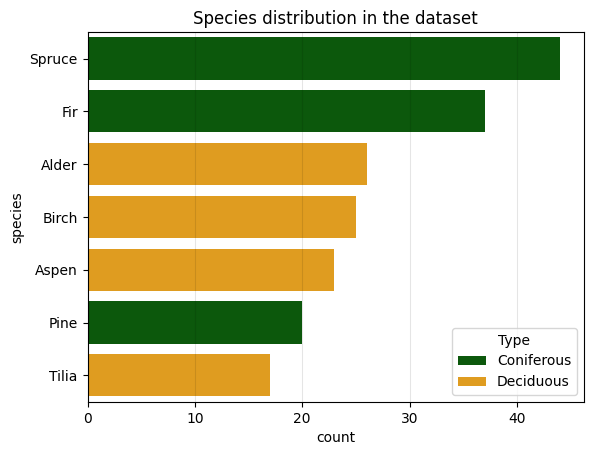

In [4]:
#| label: fig-species-count
#| fig-cap: "Distribution of tree species in the dataset. It contains 192 point clouds of individual trees: 101 coniferous and 91 deciduous."

conifers = {"Spruce", "Fir", "Pine"}
counts = data.value_counts("species").reset_index()
counts["Type"] = counts["species"].map(
    lambda x: "Coniferous" if x in conifers else "Deciduous"
)

ax = sns.barplot(
    data=counts,
    y="species",
    x="count",
    hue="Type",
    palette=["#006400", "#FFA500"],
    dodge=False,
    orient="h",
)

ax.set_title("Species distribution in the dataset")
ax.grid(axis="x", color="black", alpha=0.1)

The first experiment we report in this manuscript aims to build intuition into commonly
used features for classical machine learning on point clouds.
We set up the experiment as a classification problem with two settings: a binary one, in
which the target is the type of tree, coniferous or deciduous, and a multiclass one, in
which the target is the species directly.
The features we use include point height distribution features from
[@woodsPredictingForestStand2008] and shape features from
[@lucasIdentificationLinearVegetation2019] derived from the eigenvalues of the
covariance matrix of the coordinates.
We calculate each feature for the entire point cloud and use a 2% threshold for height
to remove ground points from the calculation, since we find they serve only as noise.
To verify that the features are meaningful and assess which are more important, we then
fit a logistic regression model on standardized feature values and look at its 10-fold
stratified cross-validation accuracy scores and feature coefficients.
Finally, we arrange each individual tree within its species group by the value of a
feature of interest and plot multiple samples from each end of the
feature range.
This allows us to associate features and their possible values with the
actual shapes of trees.

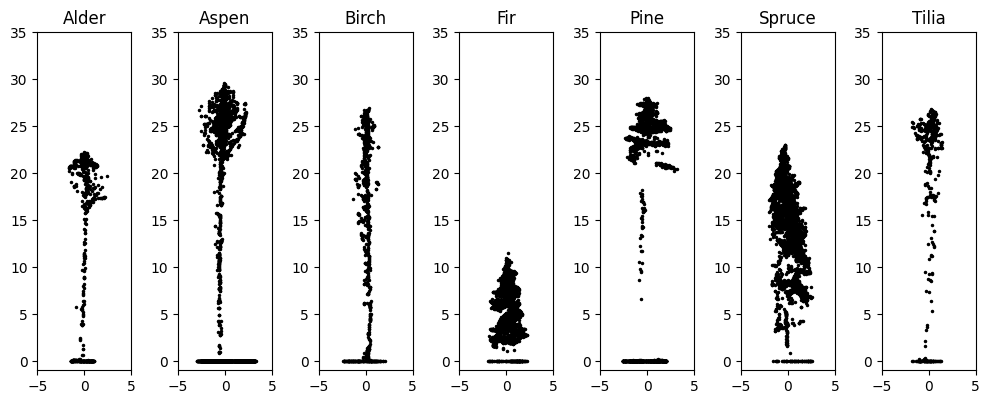

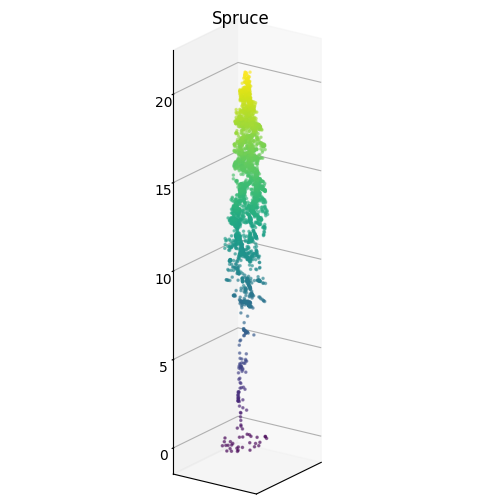

In [5]:
#| label: fig-visualization
#| layout: [[2.5, 1]]
#| fig-cap: "Visualizations of the individual tree point clouds in the dataset. Most of the tree clouds are top-heavy because of the observation from above, and some are artificially tilted because of slight terrain slopes and height normalization. The ground points are present."
#| fig-subcap:
#|  - "Cross-sections of random trees of every species (ignoring the Y dimension)."
#|  - "A spruce in 3D."

rng = np.random.default_rng(seed=1917)

unique_species = data["species"].unique()

fig, axes = plt.subplots(1, len(unique_species), figsize=(10, 7), tight_layout=True)

for ax, species in zip(axes, unique_species):
    sample = (
        data[data["species"] == species]
        .sample(n=1, random_state=rng)
        .reset_index(drop=True)
    )
    las = laspy.read(sample.loc[0, "path"])
    X, Y, Z = np.rollaxis(las.xyz, axis=1)  # (N, dim) -> (dim, N)
    ax.plot(X - X.mean(), Z, marker=".", linestyle="", markersize=3, color="k")
    ax.set_aspect("equal")
    ax.set_title(sample.loc[0, "species"])
    ax.set_ylim(-1, 35)
    ax.set_xlim(-5, 5)


fig = plt.figure(figsize=(10, 6))

spruce = data.query("species == 'Spruce'")
sample = spruce.sample(n=1, random_state=65).reset_index(drop=True)
las = laspy.read(sample.loc[0, "path"])
X, Y, Z = np.rollaxis(las.xyz, axis=1)

ax = fig.add_subplot(projection="3d")
ax.scatter(
    X - X.mean(), Y - Y.mean(), Z, s=10, c=Z, marker=".", alpha=0.5, cmap="viridis"
)
ax.set_proj_type("ortho")
ax.set_aspect("equal")
ax.view_init(elev=20, azim=35, roll=0)
ax.set_title(sample.loc[0, "species"])
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-1, 22)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

The second experiment is also set up as a multiclass classification problem.
Instead of encoding the shape of the point cloud through features based on distributions
of heights and eigenvalues of the covariance matrix, we treat the whole tree cloud as a
three-dimensional distribution.
First, we construct super-trees for each species by merging multiple scaled and centered
point clouds into one.
Figure  @fig-super-trees} shows examples of such super-trees for birch and fir,
visualized as a scatter plot with very low alpha and as a hex 2D histogram.
Then, each super-tree is used to fit a kernel density estimator by treating each point
as a three-dimensional observation.
They can then be used to estimate the likelihood of individual trees belonging to the
same distribution as each of the super-trees.

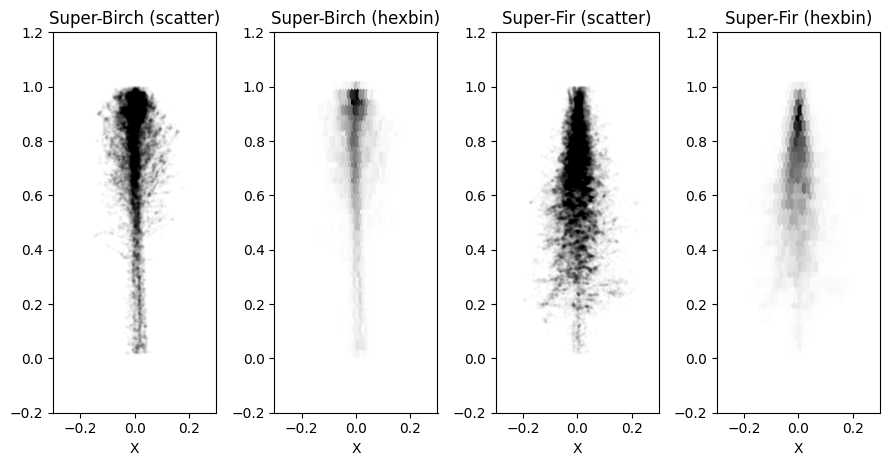

In [6]:
#| label: fig-super-trees
#| fig-cap: "Super-trees for birch and fir as a scatter plot with very low alpha and as a hex 2D histogram. A super-tree for a species is a collection of tree clouds of that species centered, scaled, and merged into one."

def get_super_tree(species: str) -> np.ndarray:
    """Construct a super-tree for the specified species."""

    clouds = [laspy.read(p).xyz for p in data.query(f"species == '{species}'")["path"]]

    assert len(clouds) > 0, "No trees found. Is the species name correct?"

    # Center and scale
    for xyz in clouds:
        means = xyz.mean(axis=0, keepdims=True)
        means[0][-1] = 0  # Don't recenter Z
        xyz -= means
        xyz /= xyz[:, 2].max()

    return np.vstack(clouds)


fig, axes = plt.subplots(1, 4, figsize=(9, 5), tight_layout=True)

for i, species in enumerate(["Birch", "Fir"]):
    super_tree = get_super_tree(species)
    X, Y, Z = np.rollaxis(super_tree, axis=1)

    height_mask = Z > 0.02
    X, Y, Z = X[height_mask], Y[height_mask], Z[height_mask]

    ax = axes[i * 2]
    ax.plot(X, Z, marker=".", linestyle="", markersize=3, color="k", alpha=0.01)
    ax.set_xlabel("X")

    ax.set_aspect("equal")
    ax.set_ylim(-0.2, 1.2)
    ax.set_xlim(-0.3, 0.3)

    ax.set_title(f"Super-{species} (scatter)")

for i, species in enumerate(["Birch", "Fir"]):
    super_tree = get_super_tree(species)
    X, Y, Z = np.rollaxis(super_tree, axis=1)

    height_mask = Z > 0.02
    X, Y, Z = X[height_mask], Y[height_mask], Z[height_mask]

    ax = axes[i * 2 + 1]
    ax.hexbin(X, Z, cmap="binary", gridsize=30)
    ax.set_xlabel("X")

    ax.set_aspect("equal")
    ax.set_ylim(-0.2, 1.2)
    ax.set_xlim(-0.3, 0.3)

    ax.set_title(f"Super-{species} (hexbin)")

fig.savefig(f"super-trees.png", dpi=300)

We make the data and code used in this study available through Kaggle
[@dubrovinIndividualTreesUAV2023]. The notebooks there contain additional visualizations
and experiments and are easy to copy, run, and modify in pinned environments without
installing anything locally. We only report two experiments here due to limitations on
the length of the manuscript.